<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/homography_ex7_DeepLK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/placeforyiming/CVPR21-Deep-Lucas-Kanade-Homography.git

Cloning into 'CVPR21-Deep-Lucas-Kanade-Homography'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 147 (delta 56), reused 114 (delta 33), pack-reused 0
Receiving objects: 100% (147/147), 35.30 MiB | 19.35 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
!gdown --id 1karVQMlh3FOMMa2cTYS35GdehdAt7lW5
!unzip -q checkpoints.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1karVQMlh3FOMMa2cTYS35GdehdAt7lW5
To: /content/checkpoints.zip
100% 531M/531M [00:03<00:00, 155MB/s]


In [ ]:
import sys
sys.path.append('./CVPR21-Deep-Lucas-Kanade-Homography/model_ours')

In [ ]:
from data_read import *
from net import *
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from PIL import Image

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="MSCOCO",help='MSCOCO,GoogleMap,GoogleEarth,DayNight')
parser.add_argument('--epoch_load_one', action="store", dest="epoch_load_one", type=int, default=3,help='epoch_load_one')
parser.add_argument('--epoch_load_two', action="store", dest="epoch_load_two", type=int, default=3,help='epoch_load_two')
parser.add_argument('--epoch_load_three', action="store", dest="epoch_load_three", type=int, default=3,help='epoch_load_three')
parser.add_argument('--num_iters', action="store", dest="num_iters", type=int, default=100,help='num_iters')
parser.add_argument('--feature_map_type', action="store", dest="feature_map_type", default='special',help='regular or special')
parser.add_argument('--initial_type', action="store", dest="initial_type", default='multi_net',help='vanilla, simple_net, multi_net')
parser.add_argument('--load_epoch_simplenet', action="store", dest="load_epoch_simplenet", default=50,help='load_epoch_simplenet')
parser.add_argument('--load_epoch_multinet', action="store", dest="load_epoch_multinet", default=[50,50,40],help='load_epoch_multinet')

input_parameters = parser.parse_args([])

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def construct_matrix_regression(batch_size,network_output,network_output_2=[0]):
    extra=tf.ones((batch_size,1))
    predicted_matrix=tf.concat([network_output,extra],axis=-1)
    predicted_matrix=tf.reshape(predicted_matrix,[batch_size,3,3])
    if len(np.shape(network_output_2))>1:
        predicted_matrix_2=tf.concat([network_output_2,extra],axis=-1)
        predicted_matrix_2=tf.reshape(predicted_matrix_2,[batch_size,3,3])
    hh_matrix=[]
    for i in range(batch_size):
        if len(np.shape(network_output_2))>1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i,:,:],predicted_matrix[i,:,:])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i,:,:]))
        #hh_matrix.append(predicted_matrix[i,:,:])
    
    #return tf.linalg.inv(predicted_matrix+0.0001)
    return np.asarray(hh_matrix)

In [ ]:
def construct_matrix(initial_matrix,scale_factor,batch_size):
    #scale_factor size_now/(size to get matrix)
    initial_matrix=tf.cast(initial_matrix,dtype=tf.float32)
    
    scale_matrix=np.eye(3)*scale_factor
    scale_matrix[2,2]=1.0
    scale_matrix=tf.cast(scale_matrix,dtype=tf.float32)
    scale_matrix_inverse=tf.linalg.inv(scale_matrix)

    scale_matrix=tf.expand_dims(scale_matrix,axis=0)
    scale_matrix=tf.tile(scale_matrix,[batch_size,1,1])

    scale_matrix_inverse=tf.expand_dims(scale_matrix_inverse,axis=0)
    scale_matrix_inverse=tf.tile(scale_matrix_inverse,[batch_size,1,1])

    final_matrix=tf.matmul(tf.matmul(scale_matrix,initial_matrix),scale_matrix_inverse)
    return final_matrix

In [ ]:
def calculate_feature_map(input_tensor):
    bs,height,width,channel=tf.shape(input_tensor)
    path_extracted=tf.image.extract_patches(input_tensor, sizes=(1,3,3,1), strides=(1,1,1,1), rates=(1,1,1,1), padding='SAME')
    path_extracted=tf.reshape(path_extracted,(bs,height,width,channel,9))
    path_extracted_mean=tf.math.reduce_mean(path_extracted,axis=3,keepdims=True)

    #path_extracted_mean=tf.tile(path_extracted_mean,[1,1,1,channel,1])
    path_extracted=path_extracted-path_extracted_mean
    path_extracted_transpose=tf.transpose(path_extracted,(0,1,2,4,3))
    variance_matrix=tf.matmul(path_extracted_transpose,path_extracted)
    
    tracevalue=tf.linalg.trace(variance_matrix)
    row_sum=tf.reduce_sum(variance_matrix,axis=-1)
    max_row_sum=tf.math.reduce_max(row_sum,axis=-1)
    min_row_sum=tf.math.reduce_min(row_sum,axis=-1)
    mimic_ratio=(max_row_sum+min_row_sum)/2.0/tracevalue
    
    return  tf.expand_dims(mimic_ratio,axis=-1)

In [ ]:
checkpoint_dir = 'checkpoints'

load_path_one=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'level_one')
load_path_two=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'level_two')
load_path_three=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'level_three')

level_one_input=ResNet_first_input()
level_one_template=ResNet_first_template()
level_two_input=ResNet_second_input()
level_two_template=ResNet_second_template()
level_three_input=ResNet_third_input()
level_three_template=ResNet_third_template()

In [ ]:
level_one_input.load_weights(os.path.join(load_path_one, 'epoch_'+str(input_parameters.epoch_load_one)+"input_full"))
level_one_template.load_weights(os.path.join(load_path_one, 'epoch_'+str(input_parameters.epoch_load_one)+"template_full"))
level_two_input.load_weights(os.path.join(load_path_two, 'epoch_'+str(input_parameters.epoch_load_two)+"input_full"))
level_two_template.load_weights(os.path.join(load_path_two, 'epoch_'+str(input_parameters.epoch_load_two)+"template_full"))
level_three_input.load_weights(os.path.join(load_path_three, 'epoch_'+str(input_parameters.epoch_load_three)+"input_full"))
level_three_template.load_weights(os.path.join(load_path_three, 'epoch_'+str(input_parameters.epoch_load_three)+"template_full"))

In [ ]:
save_path_one=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'regression_stage_1')
save_path_two=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'regression_stage_2')
save_path_three=os.path.join(checkpoint_dir, input_parameters.dataset_name, 'regression_stage_3')

regression_network_one=Net_first()
regression_network_one.load_weights(os.path.join(save_path_one, 'epoch_'+str(input_parameters.load_epoch_multinet[0])))
regression_network_two=Net_second()
regression_network_two.load_weights(os.path.join(save_path_two, 'epoch_'+str(input_parameters.load_epoch_multinet[1])))
regression_network_three=Net_third()
regression_network_three.load_weights(os.path.join(save_path_three, 'epoch_'+str(input_parameters.load_epoch_multinet[2])))

In [ ]:
LK_layer_one=Lucas_Kanade_layer(batch_size=1,height_template=128,width_template=128,num_channels=1)
LK_layer_two=Lucas_Kanade_layer(batch_size=1,height_template=64,width_template=64,num_channels=1)
LK_layer_three=Lucas_Kanade_layer(batch_size=1,height_template=32,width_template=32,num_channels=1)
LK_layer_regression=Lucas_Kanade_layer(batch_size=1,height_template=192,width_template=192,num_channels=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

In [ ]:
def compute_homography(img1, img2):
    input_img = img1.astype(np.float32) / 255
    template_img = img2.astype(np.float32) / 255
    input_img = np.expand_dims(input_img, 0)
    template_img = np.expand_dims(template_img, 0)

    input_img_grey=tf.image.rgb_to_grayscale(input_img)

    template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
    template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
    network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
    homography_vector_one=regression_network_one.call(network_input,training=False)

    matrix_one=construct_matrix_regression(1,homography_vector_one)

    template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
    template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
    network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
    homography_vector_two=regression_network_two.call(network_input,training=False)

    matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)

    template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
    template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
    network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
    homography_vector_three=regression_network_three.call(network_input,training=False)

    extra=tf.ones((1,1))
    initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
    initial_matrix=tf.reshape(initial_matrix,[1,3,3])
    initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
    initial_matrix=np.expand_dims(initial_matrix,axis=0)
    initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)

    input_feature_map_one=calculate_feature_map(input_feature_one)
    template_feature_map_one=calculate_feature_map(template_feature_one)

    input_feature_map_two=calculate_feature_map(input_feature_two)
    template_feature_map_two=calculate_feature_map(template_feature_two)

    input_feature_map_three=calculate_feature_map(input_feature_three)
    template_feature_map_three=calculate_feature_map(template_feature_three)

    updated_matrix=initial_matrix
    fk_loop=input_parameters.num_iters

    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')

    return updated_matrix[0].numpy()

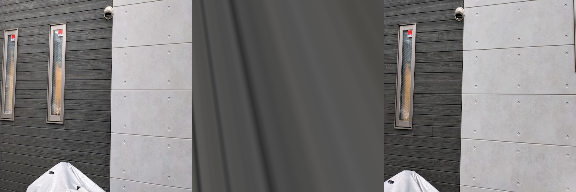

In [ ]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

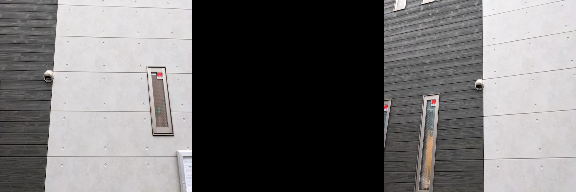

In [ ]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

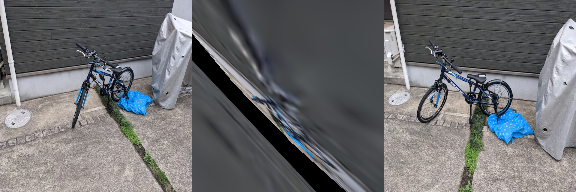

In [ ]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

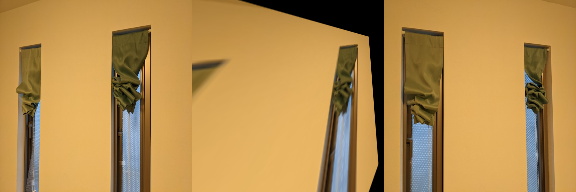

In [ ]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

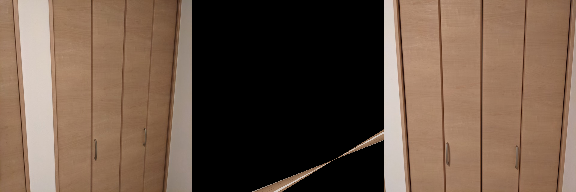

In [ ]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

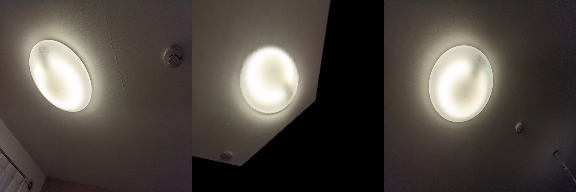

In [ ]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

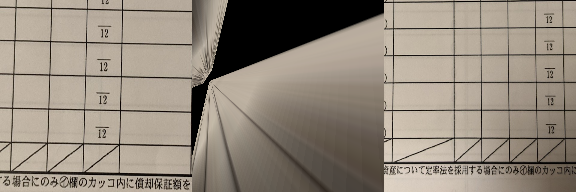

In [ ]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))

In [ ]:
def ImagePreProcessing(img):
    img = cv2.resize(img,(320,240))

    rho          = 32
    patch_size   = 192
    top_point    = (32,32)
    left_point   = (patch_size+32, 32)
    bottom_point = (patch_size+32, patch_size+32)
    right_point  = (32, patch_size+32)
    test_image = img.copy()
    four_points = [top_point, left_point, bottom_point, right_point]

    perturbed_four_points = []
    for point in four_points:
        perturbed_four_points.append((point[0] + random.randint(-rho,rho), point[1]+random.randint(-rho,rho)))

    H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
    H_inverse = np.linalg.inv(H)

    warped_image = cv2.warpPerspective(img,H_inverse, (320,240))

    annotated_warp_image = warped_image.copy()

    Ip1 = test_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]
    Ip2 = warped_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]

    training_image = np.dstack((Ip1, Ip2))
    H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
    datum = (training_image, H_four_points)
    
    return datum

!wget https://learnopencv.com/wp-content/uploads/2016/01/homography-example.jpg -O image.jpg

img_cv2 = cv2.imread('image.jpg')
h, w, _ = img_cv2.shape
left_img_cv2 = img_cv2[:,:w//2]

training_image, H_four_points = ImagePreProcessing(left_img_cv2)

cv2.imwrite('img_patch_1.jpg', training_image[:,:,0:3])
cv2.imwrite('img_patch_2.jpg', training_image[:,:,3:6])

--2022-04-20 17:55:03--  https://learnopencv.com/wp-content/uploads/2016/01/homography-example.jpg
Resolving learnopencv.com (learnopencv.com)... 172.66.41.41, 172.66.42.215, 2606:4700:3108::ac42:2ad7, ...
Connecting to learnopencv.com (learnopencv.com)|172.66.41.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71137 (69K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  69.47K  --.-KB/s    in 0.008s  

2022-04-20 17:55:03 (8.99 MB/s) - ‘image.jpg’ saved [71137/71137]



True

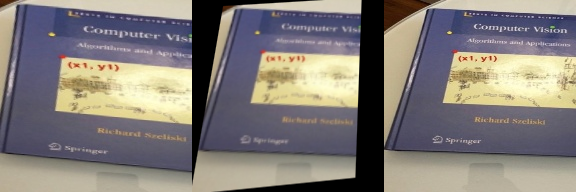

In [ ]:
img1 = cv2.imread('img_patch_1.jpg')
img2 = cv2.imread('img_patch_2.jpg')

img1 = cv2.resize(img1, (192, 192))
img2 = cv2.resize(img2, (192, 192))
img2_resized = cv2.resize(img2, (128, 128))
H = compute_homography(img1, img2_resized)

tmp = cv2.warpPerspective(img2_resized, H, (192,192))
Image.fromarray(cv2.cvtColor(np.concatenate((img2, tmp, img1), axis=1), cv2.COLOR_BGR2RGB))